In [1]:
import math
import numpy as np
import pandas as pd
from ces_direct_energy_utils import *

In [2]:
## scenario switch
case=3 # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0 # 1 means logit estimations of supply elasticity; 0 means fixed elasticities

## parameter values
theta = 4             # scopevec for comparative advantage
sigma = 1      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1  # elasticity of demand for each individual manufactured good j at Foreign
sigmaE = 1
sigmaEstar = 1

# beta gamma not used in the code unless logit indicated
beta=1.892412
gamma=0.807998928

In [3]:
# carbon content per unit of energy
h1 = 1
h2 = 0

# elasticity of supply of renewables
epsilonSstar1 = 0.5
epsilonS1 = 0.5
epsilonSstar2 = 0.5
epsilonS2 = 0.5

# make sure that epsilonSvec and epsilonSstarvec have equal length
# if a country does not have that energy source, set proportion to 0
epsilonSvec = [(epsilonS1, 1, 0.867), (epsilonS2, h2, 0.133)]
epsilonSstarvec = [(epsilonSstar1, 1,0.867), (epsilonSstar2, h2, 0.133)]

# baseline, no renewable energy
epsilonSvec = [(epsilonS1, h1, 1), (epsilonS2, h2, 0)]
epsilonSstarvec = [(epsilonSstar1, h1, 1), (epsilonSstar2, h2, 0)]
assert(sum(k for i,j,k in epsilonSvec) == 1)
assert(sum(k for i,j,k in epsilonSstarvec) == 1)

In [4]:
## import BAU values (seven regional scenarios in the order of US, EU, OECD, World, China, OECD plus China)
if case==2:
    df = pd.read_csv("../../raw_data/BaselineCarbon_2015_noTradeinGoods.csv",index_col=['region_scenario','regionbase'],header='infer')
elif case==3:
    # comment out if running simulation with no renewables
    #df = pd.read_csv("../../raw_data/BaselineCarbon_2015.csv", index_col=['regionbase'],header='infer')
    df = pd.read_csv("../../raw_data/BaselineCarbon_direct_cons.csv", index_col=['regionbase'],header='infer')
df['jxbar']=df['CeFH']/(df['CeFH'] + df['CeFF'])
df['jmbar']=df['CeHH']/(df['CeHH'] + df['CeHF'])

## choose which regional scenario to run (runs all if not executed)
#df=df.drop([2,3,4,5,6,7])  
df = df[df['region_scenario'] == 3]
#df = df[df['region_scenario'] != 4]
df

,region_scenario,Qe,Qestar,Qeworld,CeHH_old,CeHF,CeFH,CeFF_old,Ce,Cestar,...,Gestar,Ceworld,Geworld,Unnamed: 15,Cec,Cecstar,CeHH,CeFF,jxbar,jmbar
regionbase,,,,,,,,,,,,,,,,,,,,,
OECD37 as Home,3,8.62549,23.6505,32.27599,11.29367,2.48754,0.91057,17.58421,13.78121,18.49478,...,14.795824,32.27599,32.27599,NaN,2.756242,3.698956,8.537428,13.885254,0.061542,0.774372


In [5]:
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','global','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid'], 'Base':[0,1,1,1,1,1,1,1,1]},index=[1,2, 3, 4, 5, 6, 7, 8,9])
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid'], 'Base':[0,1,1,1,1,1,1,1]},index=[1,2, 3, 4, 5, 6, 7, 8])
#tax_scenario= pd.DataFrame({'tax_sce': ['PC_hybrid'], 'Base':[1]},index=[1])
tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral'], 'Base':[0]},index=[1])

In [6]:
def iterate_tax(tax_scenario,df,theta, sigma, sigmastar, sigmaC, sigmaCstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit):
    paralist = (theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit)
    varphilist = np.arange(0,3,0.1)
    #varphilist = np.arange (0,1,0.2)
    #varphilist = [0]
    output=[]
    prevtb = []
    for varphi in varphilist:    
        tax_df=df.apply(iterate_region, axis=1, raw=False, args=(prevtb, varphi, tax_scenario, paralist))
        prevtb = tax_df[['region_scenario','tb', 'pe', 'te', 'prop']]
        output.append(tax_df)
        print(varphi)
        
    output = pd.concat(output, axis=0, join='outer',  ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    output.reset_index(level=0, inplace=True)
    output = output.sort_values(by=['region_scenario','varphi'])
    
    # if extraction tax too large home stops extracting
    if tax_scenario['tax_sce']=='purete' or tax_scenario['tax_sce']=='EP_hybrid' or tax_scenario['tax_sce'] == 'Unilateral':
        output.te[output.Qe_prime==0]=output.pe+output.tb
    print(tax_scenario['tax_sce'])
    return output

In [7]:
def iterate_region(df, prevtb, varphi, tax_scenario, paralist):
    # initial guess if previous value isn't available
    pe = 1
    te = 0.5
    tb_mat = [0,0.5]
    
    # use previous vector of solution if available
    if (type(prevtb) != list):
        curr_region = prevtb[prevtb['region_scenario'] == df['region_scenario']]
        vals = curr_region.values
        tb_mat = [vals[0][1], vals[0][4]]
        pe = vals[0][2]
        te = vals[0][3]
    tax_temp = tax_eq(pe, te, tb_mat, df, tax_scenario, varphi, paralist)
    tax_temp.opt_tax()
    ret = tax_temp.retrieve()
    return ret

In [8]:
temp_df = tax_scenario.apply(iterate_tax, axis=1, args=(df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit))

C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\simulation_results\codes\direct_energy_consumption\ces_direct_energy_utils.py:627: RuntimeWarning: invalid value encountered in double_scalars
  leakage1 = -(Qestar_prime - df['Qestar']) / (Qeworld_prime - df['Qeworld'])
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\simulation_results\codes\direct_energy_consumption\ces_direct_energy_utils.py:628: RuntimeWarning: invalid value encountered in double_scalars
  leakage2 = -(Gestar_prime - df['Gestar']) / (Qeworld_prime - df['Qeworld'])
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\simulation_results\codes\direct_energy_consumption\ces_direct_energy_utils.py:629: RuntimeWarning: invalid value encountered in double_scalars
  leakage3 = -(Cestar_prime - df['Cestar']) / (Qeworld_prime - df['Qeworld'])
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\simulation_results\codes\direct_energy_consumption\ces_direct_energy_utils.py

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
Unilateral


In [9]:
output_list=[]
for i in range(1,len(tax_scenario)+1):
    output_list.append(temp_df.loc[i])
Outcomes = pd.concat(output_list, axis=0, join='outer', ignore_index=False, keys=tax_scenario['tax_sce'], levels=None, verify_integrity=False,copy=True)
Outcomes.reset_index(level=0, inplace=True)
Outcomes

,tax_sce,regionbase,varphi,pe,tb,prop,te,jxbar_prime,jmbar_prime,j0_prime,...,delta_Vg,delta_Vgstar,welfare,welfare_noexternality,Qe1_prime,Qe1star_prime,Qe2_prime,Qe2star_prime,region_scenario,conv
0,Unilateral,OECD37 as Home,0.0,1.000000,0.000000,0.500000,0.000000,0.054860,0.778624,0.054860,...,-0.000000,-0.000000,-0.000000,0.000000,8.625490,23.650500,0.0,0.0,3.0,1.0
1,Unilateral,OECD37 as Home,0.1,0.993667,0.039978,0.682823,0.100000,0.054881,0.778624,0.053646,...,-0.456041,0.077929,-0.062978,-0.102825,8.334407,23.575488,0.0,0.0,3.0,1.0
2,Unilateral,OECD37 as Home,0.2,0.988370,0.079571,0.190872,0.200000,0.054941,0.778624,0.052500,...,-0.905871,0.139496,-0.086949,-0.245344,8.035795,23.512569,0.0,0.0,3.0,1.0
3,Unilateral,OECD37 as Home,0.3,0.984048,0.118885,0.126721,0.300000,0.055037,0.778624,0.051418,...,-1.350177,0.185361,-0.072400,-0.426977,7.728998,23.461101,0.0,0.0,3.0,1.0
4,Unilateral,OECD37 as Home,0.4,0.980651,0.158020,0.095672,0.400000,0.055166,0.778624,0.050393,...,-1.789660,0.216024,-0.019704,-0.647579,7.413264,23.420580,0.0,0.0,3.0,1.0
5,Unilateral,OECD37 as Home,0.5,0.978145,0.197075,0.079921,0.500000,0.055327,0.778624,0.049422,...,-2.225049,0.231830,0.070879,-0.907431,7.087717,23.390632,0.0,0.0,3.0,1.0
6,Unilateral,OECD37 as Home,0.6,0.976505,0.236143,0.064919,0.600000,0.055516,0.778624,0.048499,...,-2.657104,0.232958,0.199203,-1.207264,6.751329,23.371015,0.0,0.0,3.0,1.0
7,Unilateral,OECD37 as Home,0.7,0.975720,0.275319,0.053339,0.700000,0.055732,0.778624,0.047621,...,-3.086637,0.219411,0.365233,-1.548293,6.402873,23.361621,0.0,0.0,3.0,1.0
8,Unilateral,OECD37 as Home,0.8,0.975793,0.314699,0.047319,0.800000,0.055972,0.778624,0.046786,...,-3.514535,0.190992,0.569048,-1.932292,6.040875,23.362492,0.0,0.0,3.0,1.0
9,Unilateral,OECD37 as Home,0.9,0.976741,0.354386,0.044776,0.900000,0.056237,0.778624,0.045988,...,-3.941786,0.147264,0.810839,-2.361704,5.663521,23.373841,0.0,0.0,3.0,1.0


In [10]:
Outcomes[['pe','tb', 'Cec_prime', 'Cecstar_prime', 'Cey_prime', 'Cex_prime', 'Cem_prime', 'Ceystar_prime', 'Vgx_prime', 'Vgm_prime']]

,pe,tb,Cec_prime,Cecstar_prime,Cey_prime,Cex_prime,Cem_prime,Ceystar_prime,Vgx_prime,Vgm_prime
0,1.000000,0.000000,2.544500,1.896700,8.749170,0.910570,2.487540,15.687510,6.070467,16.5836
1,0.993667,0.039978,2.461677,1.908789,8.464385,0.881324,2.406571,15.787150,6.072764,16.5836
2,0.988370,0.079571,2.382623,1.919018,8.192561,0.854126,2.329286,15.870748,6.079404,16.5836
3,0.984048,0.118885,2.307032,1.927447,7.932645,0.828749,2.255388,15.938837,6.090039,16.5836
4,0.980651,0.158020,2.234621,1.934123,7.683664,0.804992,2.184598,15.991846,6.104363,16.5836
5,0.978145,0.197075,2.165127,1.939078,7.444709,0.782676,2.116659,16.030101,6.122106,16.5836
6,0.976505,0.236143,2.098301,1.942335,7.214930,0.761638,2.051329,16.053809,6.143026,16.5836
7,0.975720,0.275319,2.033910,1.943897,6.993524,0.741732,1.988379,16.063051,6.166908,16.5836
8,0.975793,0.314699,1.971728,1.943753,6.779716,0.722823,1.927590,16.057757,6.193557,16.5836
9,0.976741,0.354386,1.911538,1.941865,6.572753,0.704782,1.868747,16.037677,6.222798,16.5836


In [11]:
#outcome_t = Outcomes[Outcomes['regionbase'] == 'US as Home']
Outcomes[['pe','tb', 'Qe_prime', 'Qestar_prime','Lg_prime','Lgstar_prime', 'Vg_prime', 'Vgstar_prime', 'Vgx2_prime', 'delta_Le','delta_Lestar','welfare','welfare_noexternality']]

,pe,tb,Qe_prime,Qestar_prime,Lg_prime,Lgstar_prime,Vg_prime,Vgstar_prime,Vgx2_prime,delta_Le,delta_Lestar,welfare,welfare_noexternality
0,1.000000,0.000000,8.625490,23.650500,54.738527,102.991950,74.911400,64.398267,0.000000,0.000000,0.000000,-0.000000,0.000000
1,0.993667,0.039978,8.334407,23.575488,54.740831,102.989997,72.988192,62.144610,0.136664,-0.281370,-0.074774,-0.062978,-0.102825
2,0.988370,0.079571,8.035795,23.512569,54.747517,102.984353,71.196099,60.061270,0.270043,-0.550298,-0.137129,-0.086949,-0.245344
3,0.984048,0.118885,7.728998,23.461101,54.758271,102.975314,69.522242,58.130711,0.400446,-0.806543,-0.187887,-0.072400,-0.426977
4,0.980651,0.158020,7.413264,23.420580,54.772820,102.963138,67.955344,56.337666,0.528150,-1.049841,-0.227692,-0.019704,-0.647579
5,0.978145,0.197075,7.087717,23.390632,54.790920,102.948056,66.485504,54.668809,0.653404,-1.279907,-0.257023,0.070879,-0.907431
6,0.976505,0.236143,6.751329,23.371015,54.812356,102.930274,65.104005,53.112467,0.776429,-1.496434,-0.276195,0.199203,-1.207264
7,0.975720,0.275319,6.402873,23.361621,54.836933,102.909975,63.803157,51.658390,0.897422,-1.699086,-0.285365,0.365233,-1.548293
8,0.975793,0.314699,6.040875,23.362492,54.864480,102.887323,62.576156,50.297549,1.016560,-1.887496,-0.284515,0.569048,-1.932292
9,0.976741,0.354386,5.663521,23.373841,54.894838,102.862468,61.416986,49.021986,1.133997,-2.061264,-0.273436,0.810839,-2.361704


In [12]:
Outcomes.to_csv('../../output_renewable/direct_consumption.csv'.format(theta, case), header=True)

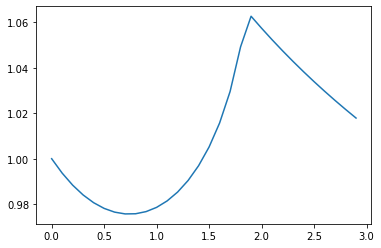

In [13]:
import matplotlib.pyplot as plt
plt.plot(Outcomes['varphi'], Outcomes['pe'])

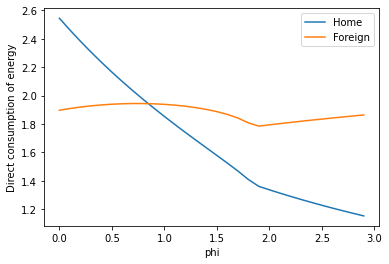

In [19]:
plt.plot(Outcomes['varphi'], Outcomes['Cec_prime'], label = "Home")
plt.plot(Outcomes['varphi'], Outcomes['Cecstar_prime'], label = "Foreign")
plt.xlabel("phi")
plt.ylabel("Direct consumption of energy")
plt.legend()
plt.savefig('phi_cec.pdf', format='PDF')

In [15]:
Outcomes['petb'] = Outcomes['pe'] + Outcomes['tb']

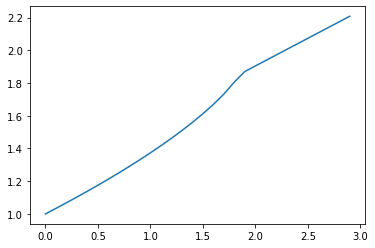

In [16]:
plt.plot(Outcomes['varphi'], Outcomes['petb'])

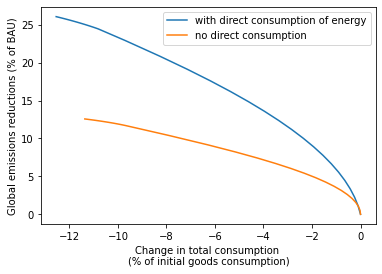

In [17]:
df = pd.read_csv('../../output/output_case3.csv')
df = df[(df['region_scenario'] == 1) & (df['tax_sce'] == 'Unilateral') & (df['varphi'] <= 3)]
Outcomes['Qeworld_chg']=-(Outcomes['Qeworld_prime']-32.2760)/32.2760*100
plt.plot(Outcomes['welfare_noexternality'], Outcomes['Qeworld_chg'], label = 'with direct consumption of energy')

df['Qeworld_chg']=-(df['Qeworld_prime']-32.2760)/32.2760*100
plt.plot(df['welfare_noexternality'], df['Qeworld_chg'], label = 'no direct consumption')

plt.xlabel('Change in total consumption \n(% of initial goods consumption)')
plt.ylabel('Global emissions reductions (% of BAU)')
plt.legend()

plt.savefig('wf_chg.pdf', format = 'PDF')

In [18]:
df

,regionbase,tax_sce,region_scenario,tb,prop,te,varphi,pe,jxbar_prime,jmbar_prime,...,chg_extraction,chg_production,chg_consumption,chg_Qeworld,pai_g,subsidy_ratio,welfare,welfare_noexternality,prop2,Qeworld_chg
1400,US as Home,Unilateral,1,0.000000,1.0,0.0,0.0,1.000000,0.015921,0.793579,...,-5.081055e-07,9.964702e-07,0.000002,2.100000e-07,1.027573e-07,0.000000,0.000001,0.000001,NaN,0.000030
1401,US as Home,Unilateral,1,0.034750,1.0,0.1,0.1,0.998751,0.015925,0.793579,...,-1.736544e-02,-6.304616e-03,0.018945,-1.688865e-01,-9.416008e-02,0.005192,0.021883,-0.021836,NaN,0.523288
1402,US as Home,Unilateral,1,0.069437,1.0,0.2,0.2,0.997893,0.015939,0.793579,...,-2.930035e-02,-2.091422e-02,0.028484,-3.370530e-01,-1.892437e-01,0.010330,0.087375,-0.087128,NaN,1.044315
1403,US as Home,Unilateral,1,0.104063,1.0,0.3,0.3,0.997418,0.015961,0.793579,...,-3.590396e-02,-4.381591e-02,0.028690,-5.051673e-01,-2.852293e-01,0.015409,0.196379,-0.195932,NaN,1.565179
1404,US as Home,Unilateral,1,0.138750,1.0,0.4,0.4,0.997305,0.015991,0.793579,...,-3.748537e-02,-7.467563e-02,0.020020,-6.739365e-01,-3.824052e-01,0.020442,0.348972,-0.348863,NaN,2.088073
1405,US as Home,Unilateral,1,0.173500,1.0,0.5,0.5,0.997555,0.016028,0.793579,...,-3.399704e-02,-1.136904e-01,0.002324,-8.440795e-01,-4.807806e-01,0.025425,0.545415,-0.547100,NaN,2.615223
1406,US as Home,Unilateral,1,0.208313,1.0,0.6,0.6,0.998179,0.016071,0.793579,...,-2.531544e-02,-1.611787e-01,-0.024672,-1.016409e+00,-5.803811e-01,0.030354,0.786167,-0.792512,NaN,3.149147
1407,US as Home,Unilateral,1,0.243313,1.0,0.7,0.7,0.999174,0.016121,0.793579,...,-1.148258e-02,-2.172137e-01,-0.060936,-1.191809e+00,-6.815503e-01,0.035240,1.071907,-1.087720,NaN,3.692585
1408,US as Home,Unilateral,1,0.278438,1.0,0.8,0.8,1.000574,0.016177,0.793579,...,7.978459e-03,-2.826799e-01,-0.107343,-1.371397e+00,-7.842107e-01,0.040069,1.403570,-1.436488,NaN,4.248998
1409,US as Home,Unilateral,1,0.313813,1.0,0.9,0.9,1.002399,0.016239,0.793579,...,3.331670e-02,-3.581363e-01,-0.164356,-1.556452e+00,-8.887664e-01,0.044853,1.782399,-1.843807,NaN,4.822351
